# Alzheimer's Detection

A machine learning system will be developed to detect signs of Alzheimer’s disease (AD) based on drawing patterns and handwriting. Classification models will be developed that can classify whether or not a subject shows early signs of AD using data gathered from the DARWIN dataset. 

The DARWIN dataset contains 174 labeled samples collected from 25 cognitive and motor tasks, which include drawing, writing, and retracing forms. From these different tasks, 18 kinematic features per task are used. These include features like:
- `total task time` 
- `pen pressure`
- `acceleration` 
- `air time`, etc. 

These will help the models in identifying patterns associated with cognitive decline. The goal is to train and evaluate classification models, starting with simple baselines and progressing toward more advanced models, to assess the feasibility of handwriting as a non-invasive diagnostic tool for early AD detection. This will help determine whether handwriting-based screening is a good complement to traditional diagnostic tools in real-world clinical settings.

### Import required libraries

In [298]:
import zipfile
import tempfile
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns 
from pathlib import Path

# Preprocessing tools
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA 

# Hyperparamater Tuning and Pipelines
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold

# Models to train and classify with
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier

# Scoring and Evaluation
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
from sklearn.utils.validation import check_is_fitted

### Import the Data

In [299]:
# Define OS-independent file path
data_dir = Path.cwd() / 'data'/ 'darwin-alzheimers.zip'

# Create a temp directory to extract to
with tempfile.TemporaryDirectory() as temp_output_dir:
    # Extract the zip file 
    with zipfile.ZipFile(data_dir, 'r') as zip_ref:
        zip_ref.extractall(str(temp_output_dir))

    # Get data CSV filepath
    file_path = Path(f"{str(temp_output_dir)}/data.csv")

    # Load into pandas Dataframe
    data = pd.read_csv(file_path)

In [300]:
# Visualize data
data.head()

,ID,air_time1,disp_index1,gmrt_in_air1,gmrt_on_paper1,max_x_extension1,max_y_extension1,mean_acc_in_air1,mean_acc_on_paper1,mean_gmrt1,...,mean_jerk_in_air25,mean_jerk_on_paper25,mean_speed_in_air25,mean_speed_on_paper25,num_of_pendown25,paper_time25,pressure_mean25,pressure_var25,total_time25,class
0,id_1,5160,0.000013,120.804174,86.853334,957,6601,0.361800,0.217459,103.828754,...,0.141434,0.024471,5.596487,3.184589,71,40120,1749.278166,296102.7676,144605,P
1,id_2,51980,0.000016,115.318238,83.448681,1694,6998,0.272513,0.144880,99.383459,...,0.049663,0.018368,1.665973,0.950249,129,126700,1504.768272,278744.2850,298640,P
2,id_3,2600,0.000010,229.933997,172.761858,2333,5802,0.387020,0.181342,201.347928,...,0.178194,0.017174,4.000781,2.392521,74,45480,1431.443492,144411.7055,79025,P
3,id_4,2130,0.000010,369.403342,183.193104,1756,8159,0.556879,0.164502,276.298223,...,0.113905,0.019860,4.206746,1.613522,123,67945,1465.843329,230184.7154,181220,P
4,id_5,2310,0.000007,257.997131,111.275889,987,4732,0.266077,0.145104,184.636510,...,0.121782,0.020872,3.319036,1.680629,92,37285,1841.702561,158290.0255,72575,P


In [301]:
# Get descriptive statistics on data
data.describe()

,air_time1,disp_index1,gmrt_in_air1,gmrt_on_paper1,max_x_extension1,max_y_extension1,mean_acc_in_air1,mean_acc_on_paper1,mean_gmrt1,mean_jerk_in_air1,...,mean_gmrt25,mean_jerk_in_air25,mean_jerk_on_paper25,mean_speed_in_air25,mean_speed_on_paper25,num_of_pendown25,paper_time25,pressure_mean25,pressure_var25,total_time25
count,174.000000,174.000000,174.000000,174.000000,174.000000,174.000000,174.000000,174.000000,174.000000,174.000000,...,174.000000,174.000000,174.000000,174.000000,174.000000,174.000000,174.000000,174.000000,174.000000,1.740000e+02
mean,5664.166667,0.000010,297.666685,200.504413,1977.965517,7323.896552,0.416374,0.179823,249.085549,0.067556,...,221.360646,0.148286,0.019934,4.472643,2.871613,85.839080,43109.712644,1629.585962,163061.767360,1.642033e+05
std,12653.772746,0.000003,183.943181,111.629546,1648.306365,2188.290512,0.381837,0.064693,132.698462,0.074776,...,63.762013,0.062207,0.002388,1.501411,0.852809,27.485518,19092.024337,324.142316,56845.610814,4.969397e+05
min,65.000000,0.000002,28.734515,29.935835,754.000000,561.000000,0.067748,0.096631,41.199445,0.011861,...,69.928033,0.030169,0.014987,1.323565,0.950249,32.000000,15930.000000,474.049462,26984.926660,2.998000e+04
25%,1697.500000,0.000008,174.153023,136.524742,1362.500000,6124.000000,0.218209,0.146647,161.136182,0.029523,...,178.798382,0.107732,0.018301,3.485934,2.401199,66.000000,32803.750000,1499.112088,120099.046800,5.917500e+04
50%,2890.000000,0.000009,255.791452,176.494494,1681.000000,6975.500000,0.275184,0.163659,224.445268,0.039233,...,217.431621,0.140483,0.019488,4.510578,2.830672,81.000000,37312.500000,1729.385010,158236.771800,7.611500e+04
75%,4931.250000,0.000011,358.917885,234.052560,2082.750000,8298.500000,0.442706,0.188879,294.392298,0.071057,...,264.310776,0.199168,0.021134,5.212794,3.335828,101.500000,46533.750000,1865.626974,200921.078475,1.275425e+05
max,109965.000000,0.000028,1168.328276,865.210522,18602.000000,15783.000000,2.772566,0.627350,836.784702,0.543199,...,437.373267,0.375078,0.029227,10.416715,5.602909,209.000000,139575.000000,1999.775983,352981.850000,5.704200e+06


In [302]:
# Check for missing values
missing = data.isna().sum()

missing[missing > 0]

Series([], dtype: int64)

In [303]:
# See columns by data types
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 174 entries, 0 to 173
Columns: 452 entries, ID to class
dtypes: float64(300), int64(150), object(2)
memory usage: 614.6+ KB


### Baseline Model
Train a baseline model with 80/20 split and preprocessing to scale values. No cross-validation or hyperparameter tuning yet.

#### Generate Train/Test splits

In [304]:
y = data['class']
X = data.drop(columns=['class', 'ID']) # drop unnecessary ID col

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#### Preprocess Data

In [305]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.fit_transform(X_test)

#### Train Models

In [306]:
lr = LogisticRegression()

# Fit model on training data
lr.fit(X_train_scaled, y_train)

# Generate predictions using X test set
y_hat = lr.predict(X_test_scaled)
y_train_pred = lr.predict(X_train_scaled)

#### Evaluation

In [307]:
# Get accuracy scores for baseline model
test_accuracy = lr.score(X_test_scaled, y_test)
training_accuracy = lr.score(X_train_scaled, y_train)
print(f"Training Accuracy: {training_accuracy}\nTest Accuracy: {test_accuracy}")

Training Accuracy: 1.0
Test Accuracy: 0.8571428571428571


In [308]:
# Get Precision, Recall and F1
test_report = classification_report(y_test, y_hat, output_dict=True)
train_report = classification_report(y_train, y_train_pred, output_dict=True)

train_results = train_report["P"]
test_results = test_report["P"]
print(
    f"Training Results:\n\tRecall:{train_results['recall']}\n\tPrecision:{train_results['precision']}\n\tF1:{train_results['f1-score']}"
)

print(
    f"Test Results:\n\tRecall:{test_results['recall']}\n\tPrecision:{test_results['precision']}\n\tF1:{test_results['f1-score']}"
)

Training Results:
	Recall:1.0
	Precision:1.0
	F1:1.0
Test Results:
	Recall:0.8
	Precision:0.9411764705882353
	F1:0.8648648648648649


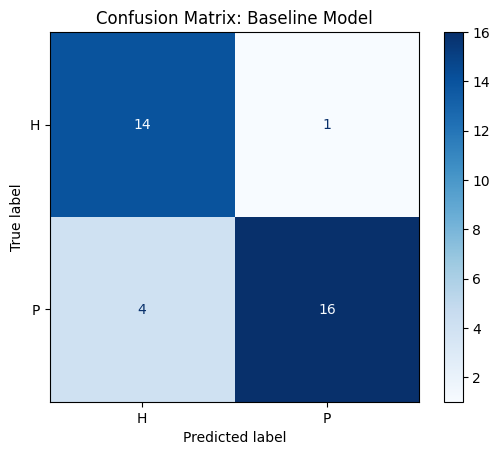

In [309]:
# Get confusion matrix
matrix = ConfusionMatrixDisplay.from_predictions(y_test, y_hat, cmap='Blues')
plt.title("Confusion Matrix: Baseline Model")
plt.show()

**Results** 
The baseline mode resulted in the following:
- Accuracy Score: 85.7%
- Confusion Matrix: 16(TP), 14(TN), 1(FP), 4(FN)
- Recall Score: 94%
- Precision Score: 80%
- F1 Score: 86%

### Pipeline For Streamlined Training
The pipeline includes the following steps:
- Stratified K-fold splits to combat imbalanced datasets
- Standard Scaling for Preprocessing
- PCA for dimensionality reduction
- Grid Search for Hyperparameter Tuning
- Evaluation and Model Selection

In [310]:
# Define models to train
models = {
    "logistic_regression": LogisticRegression(max_iter=1000),
    "knn": KNeighborsClassifier(),
    "svm": SVC(),
    "random_forest": RandomForestClassifier(),
    "mlp": MLPClassifier(max_iter=1000, )
}

# Define parameters to fine-tune
param_grids = {
    "logistic_regression": {
        "clf__C": [0.1, 1, 10],
    },
    "knn": {
        "clf__n_neighbors": [3, 5, 7],
    },
    "svm": {
        "clf__C": [0.1, 1, 10],
        "clf__kernel": ["linear", "rbf"],
    },
    "random_forest": {
        "clf__n_estimators": [100, 200],
        "clf__max_depth": [None, 10, 20]
    },
    "mlp": {
        "clf__hidden_layer_sizes": [(50,), (100,)],
        "clf__alpha": [0.0001, 0.001]
    }
}

In [311]:
# Define K-Folds
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Store results
results = {}
for name, model in models.items():
    print(f"Running: {name}_classifier..")

    # Define pipeline with preprocessing steps for each model
    pipe = Pipeline([
        ('scaler', StandardScaler()),
        ('pca', PCA(n_components=0.95)),
        ('clf', model),
    ])

    # Perform grid search cross-validation to get best hyperparams
    grid = GridSearchCV(pipe, param_grids[name], cv=skf, scoring='accuracy', n_jobs=-1)
    grid.fit(X_train, y_train)

    # Get best model for each classifier
    best_model = grid.best_estimator_
    y_hat = best_model.predict(X_test)
    y_train_pred = best_model.predict(X_train)

    # Get the parameters of the best classifier
    best_model_params = grid.best_params_

    # Get reports for train and test errors (Recall, Precision, F1)
    test_report = classification_report(y_test, y_hat, output_dict=True)
    train_report = classification_report(y_train, y_train_pred, output_dict=True)

    results[name] = {
        "model": best_model,
        "best_params": best_model_params,
        "accuracy_cv": grid.best_score_,
        "test_accuracy": best_model.score(X_test, y_test),
        "test_recall": test_report["P"]["recall"],
        "test_precision": test_report["P"]["precision"],
        "test_f1": test_report["P"]["f1-score"],
        "training_accuracy": best_model.score(X_train, y_train),
        "training_recall": train_report["P"]["recall"],
        "training_precision": train_report["P"]["precision"],
        "training_f1": train_report["P"]["f1-score"],
    }

Running: logistic_regression_classifier..
Running: knn_classifier..
Running: svm_classifier..
Running: random_forest_classifier..
Running: mlp_classifier..


#### Inspect Results

In [312]:
# Add Baseline model to results
results['baseline'] = {
    'model': lr,
    'best_params': None,
    'accuracy_cv': None,
    'test_accuracy': test_accuracy,
    'test_recall': test_results["recall"],
    'test_precision': test_results["precision"],
    'test_f1': test_results["f1-score"],
    'training_accuracy': training_accuracy,
    'training_recall': train_results["recall"],
    'training_precision': train_results["precision"],
    'training_f1': train_results["f1-score"],
}

In [313]:
df_results = pd.DataFrame(results)
df_results

,logistic_regression,knn,svm,random_forest,mlp,baseline
model,"(StandardScaler(), PCA(n_components=0.95), Log...","(StandardScaler(), PCA(n_components=0.95), KNe...","(StandardScaler(), PCA(n_components=0.95), SVC...","(StandardScaler(), PCA(n_components=0.95), (De...","(StandardScaler(), PCA(n_components=0.95), MLP...",LogisticRegression()
best_params,{'clf__C': 1},{'clf__n_neighbors': 5},"{'clf__C': 1, 'clf__kernel': 'rbf'}","{'clf__max_depth': None, 'clf__n_estimators': ...","{'clf__alpha': 0.001, 'clf__hidden_layer_sizes...",None
accuracy_cv,0.841799,0.691534,0.841799,0.856878,0.849206,None
test_accuracy,0.857143,0.571429,0.857143,0.885714,0.828571,0.857143
test_recall,0.85,0.35,0.85,0.85,0.8,0.8
test_precision,0.894737,0.777778,0.894737,0.944444,0.888889,0.941176
test_f1,0.871795,0.482759,0.871795,0.894737,0.842105,0.864865
training_accuracy,1.0,0.705036,0.992806,1.0,1.0,1.0
training_recall,1.0,0.405797,0.985507,1.0,1.0,1.0
training_precision,1.0,1.0,1.0,1.0,1.0,1.0


#### View Confusion Matrixes

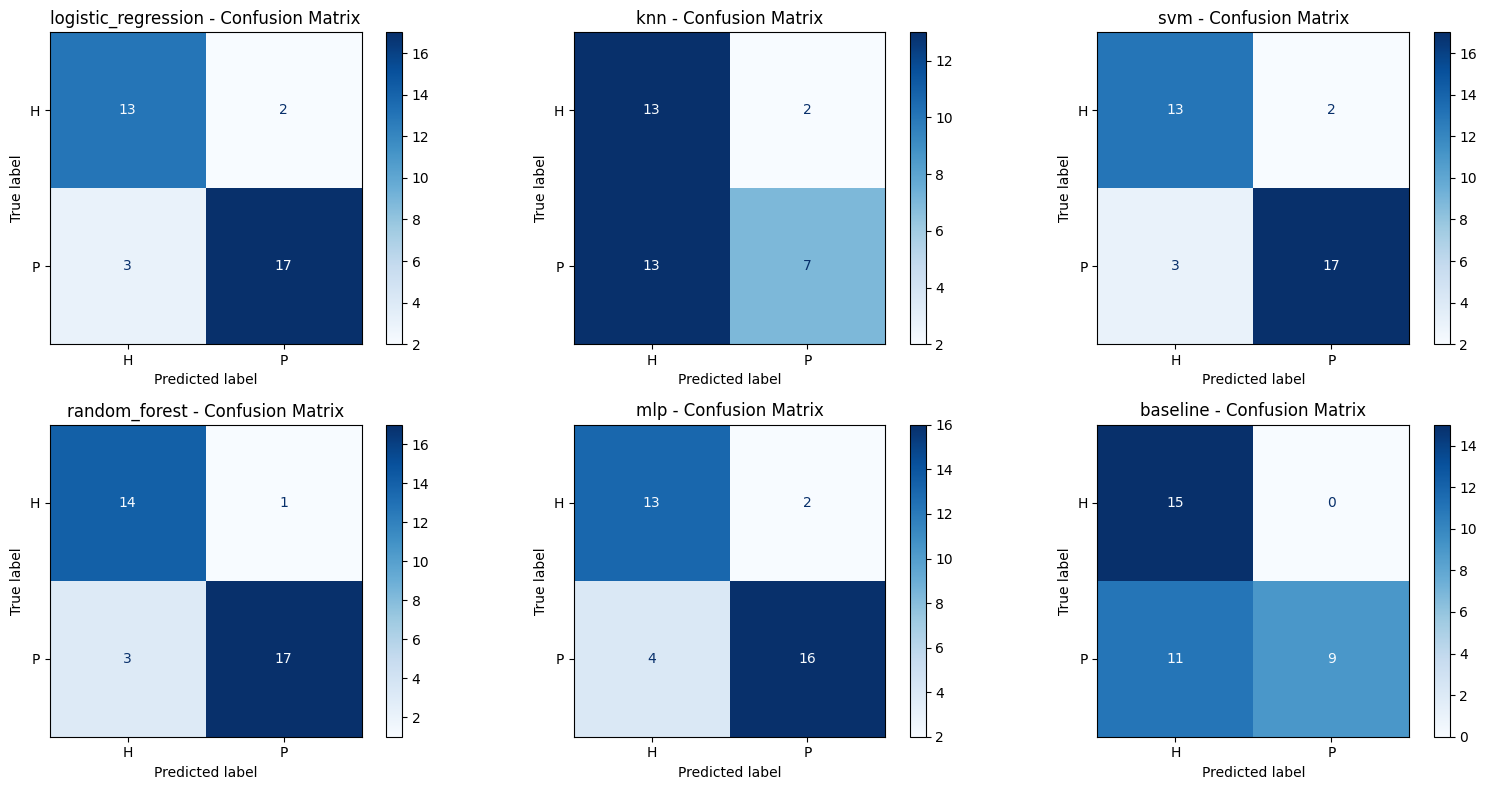

In [314]:
n_models = len(results)
n_cols = 3
n_rows = (n_models + 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(16, 4 * n_rows))

axes = axes.flatten()

for i, (name, data) in enumerate(results.items()):
    model = data["model"]
    # Use .values if model is not a pipeline
    X_input = X_test.values if not hasattr(model, "named_steps") else X_test

    # Safely check if model is fitted to avoid unexpected issues
    check_is_fitted(model)

    ConfusionMatrixDisplay.from_estimator(
        model, 
        X_input, 
        y_test, 
        cmap="Blues", 
        ax=axes[i]
    )
    axes[i].set_title(f"{name} - Confusion Matrix")

# Hide unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

#### Plot Training and Test Errors

In [315]:
# Transpose and fix structure
df_plot = df_results.T.copy()
df_plot["model_name"] = df_plot.index  # Add model name as a column
df_plot = df_plot.reset_index(drop=True)  # Reset index cleanly

# Define the metrics to plot
metrics = ["accuracy", "recall", "precision", "f1"]

# Create melted DataFrames for each metric
melted_metrics = {}
for metric in metrics:
    train_col = f"training_{metric}"
    test_col = f"test_{metric}"

    df_metric = df_plot[["model_name", train_col, test_col]].copy()
    df_metric = df_metric.rename(columns={train_col: "Train", test_col: "Test"})

    df_melted = df_metric.melt(
        id_vars="model_name", var_name="dataset", value_name=metric
    )
    melted_metrics[metric] = df_melted

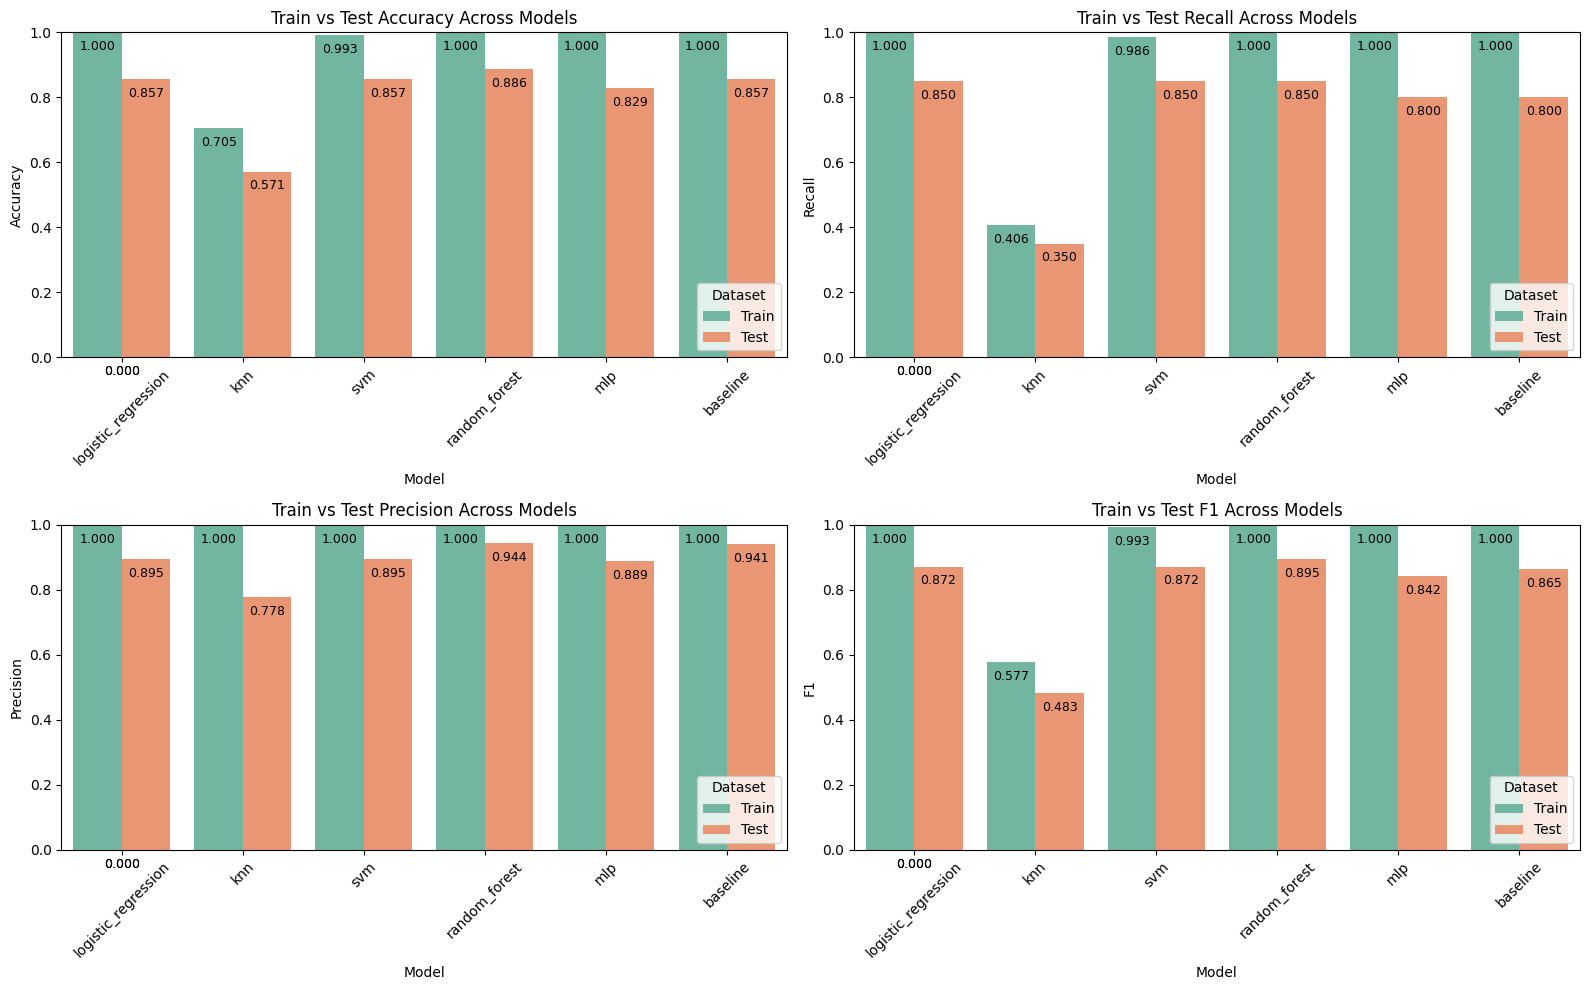

In [316]:
# Set up subplots
fig, axes = plt.subplots(2, 2, figsize=(16, 10))
axes = axes.flatten()

# Plot each metric on its own subplot
for i, metric in enumerate(metrics):
    ax = axes[i]
    sns.barplot(
        data=melted_metrics[metric],
        x="model_name",
        y=metric,
        hue="dataset",
        ax=axes[i],
        palette="Set2",
    )
    ax.set_title(f"Train vs Test {metric.capitalize()} Across Models")
    ax.set_ylabel(metric.capitalize())
    ax.set_xlabel("Model")
    ax.tick_params(axis="x", rotation=45)
    ax.set_ylim(0, 1)
    ax.legend(title="Dataset", loc="lower right")

    # Add value labels on bars
    for bar in ax.patches:
        height = bar.get_height()
        if not np.isnan(height):  # Ensure value isn't NaN
            ax.annotate(
                f"{height:.3f}",
                (bar.get_x() + bar.get_width() / 2, height),
                ha="center",
                va="bottom",
                fontsize=9,
                color="black",
                xytext=(0, -15),
                textcoords="offset points",
            )

plt.tight_layout()
plt.show()

#### Improvements

For future steps, in terms of the methodology used, different hyperparameters could be used to tune the respective models for increased results as well as performing a more nuanced dimensionality reduction with PCA. 

Additionally, performance across the models may improve if the dataset was larger. Currently, there are only 173 rows in the dataset with over 450+ features -- though that is handled with PCA.

### Final Results